In [65]:
# read in each file/ROI
# plot the coloc channel intensity for the detected spots
# plot the coloc channel intensity for the randomly placed spots

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from skimage import filters
import numpy as np
import os

usr=os.path.expanduser('~')
home_dir = f"{usr}/Dropbox (NYU Langone Health)/mac_files"
img_dir = "holtlab/data_and_results/LINE1/RNA-ORF1 Colocalization/spot_counting/20221030_LINE1"

df_dox = pd.read_csv(f"{home_dir}/{img_dir}/dox/results/ORF1-all_spots.txt", sep='\t', index_col=0)
df_dox_random = pd.read_csv(f"{home_dir}/{img_dir}/dox/results/ORF1-all_random_spots.txt", sep='\t', index_col=0)
coloc_ch_col='coloc_ch0_intensity'

In [66]:
# add normalization to the table.  
# median of random spots for each file/roi/location separately

df_dox['norm_factor']=0
for file_name in df_dox_random.file_name.unique():
    cur_df = df_dox_random[df_dox_random.file_name == file_name]
    for roi in cur_df.roi.unique():
        cur_roi_df = cur_df[cur_df.roi == roi]
        for location in cur_roi_df.location.unique():
            cur_loc_df = cur_roi_df[cur_roi_df.location==location]
            med=np.median(cur_loc_df[coloc_ch_col])
            
            df_dox.loc[(df_dox.roi==roi) & 
                       (df_dox.file_name==file_name) & 
                       (df_dox.location==location), 'norm_factor'] = med
            df_dox_random.loc[(df_dox_random.roi==roi) & 
                              (df_dox_random.file_name==file_name) & 
                              (df_dox_random.location==location), 'norm_factor'] = med
        
df_dox[f"{coloc_ch_col}-norm"]=df_dox[coloc_ch_col]/df_dox['norm_factor']
df_dox_random[f"{coloc_ch_col}-norm"]=df_dox_random[coloc_ch_col]/df_dox_random['norm_factor']

In [67]:
# Remove nuclear and save as a new file
df_dox_to_save = df_dox[df_dox.location=='cytoplasmic']
df_dox_random_to_save = df_dox_random[df_dox_random.location=='cytoplasmic']
df_dox_to_save.to_csv(f"{home_dir}/{img_dir}/dox/results/ORF1-all_spots-NORM_CYT.txt", sep='\t')
df_dox_random_to_save.to_csv(f"{home_dir}/{img_dir}/dox/results/ORF1-all_random_spots-NORM-CYT.txt", sep='\t')

In [68]:
# drop nuclear spots from all
# add ave intensity random spots vs ave intensity detected spots for each ROI
ReplicateAverages = df_dox[df_dox['roi']!=''].groupby(['file_name','roi','location'], 
                                                      as_index=False).agg({coloc_ch_col: np.mean})
ReplicateAverages['type']='detected'
ReplicateAverages['id']=ReplicateAverages['file_name']+"-"+ReplicateAverages['roi']
ReplicateAverages=ReplicateAverages[['id','type','location',coloc_ch_col]]

ReplicateAveragesRandom = df_dox_random[df_dox_random['roi']!=''].groupby(['file_name','roi','location'], 
                                                                          as_index=False).agg({coloc_ch_col: np.mean})
ReplicateAveragesRandom['type']='random'
ReplicateAveragesRandom['id']=ReplicateAveragesRandom['file_name']+"-"+ReplicateAveragesRandom['roi']
ReplicateAveragesRandom=ReplicateAveragesRandom[['id','type','location',coloc_ch_col]]

In [69]:
summary_data = pd.concat([ReplicateAverages, ReplicateAveragesRandom],axis=0)

2.0187714410982643e-12


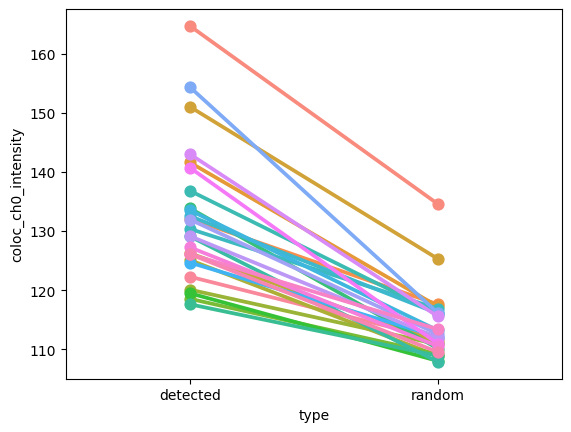

In [70]:
from scipy import stats

loc="cytoplasmic"
statistic, pvalue = stats.ttest_rel(ReplicateAverages[ReplicateAverages.location==loc][coloc_ch_col], 
                                    ReplicateAveragesRandom[ReplicateAveragesRandom.location==loc][coloc_ch_col])
print(pvalue)

# Make plot 
ax=sns.pointplot(x="type", y=coloc_ch_col, hue="id", data=summary_data[summary_data.location==loc])
ax.legend_.remove()
plt.savefig(f"{home_dir}/{img_dir}/dox/results/results-mean-int-lineplot.pdf")

In [71]:
def plot_intensity_kde(df, df_random, file_name, location, normalize, nrows, ncols, size):

    if(location != ''):
        cur_df = df[df.location==location]
        cur_df_random = df_random[df_random.location==location]
    else:
        cur_df = df
        cur_df_random = df_random
        
    cur_df = cur_df[cur_df.file_name==file_name]
    cur_random_df = cur_df_random[cur_df_random.file_name==file_name]

    fig,axs=plt.subplots(nrows, ncols, figsize=size)
    i=0; j=0
    for roi in cur_df.roi.unique():
        data = cur_df[cur_df.roi==roi][coloc_ch_col]
        data_random = cur_random_df[cur_random_df.roi==roi][coloc_ch_col]

        if(roi != '' and len(data)>0):
            #sns.histplot(x=data, ax=axs[i][j], #stat='probability', 
            #             bins=np.linspace(data.min(),data.max(),30)) #,kde=True,)
            #sns.histplot(x=data_random, ax=axs[i][j], #stat='probability', 
            #             bins=np.linspace(data.min(),data.max(),30)) #,kde=True,)
            
            
            if(normalize):
                norm_factor=np.median(data_random)
            else:
                norm_factor=1
                
            sns.kdeplot(x=data_random/norm_factor, ax=axs[i][j], label='random spots')
            sns.kdeplot(x=data/norm_factor, ax=axs[i][j], label='detected spots')
            
            m1=round(np.mean(data_random),2)
            m2=round(np.mean(data),2)
            axs[i][j].set_title(f"{roi} ({len(data)} | {len(data_random)}) ({round(norm_factor,2)})\n({m1} | {m2})")
            
            if(i == 0 and j == 0):
                axs[i][j].legend()

            if(j == (ncols-1)):
                i+=1; j=0
            else:
                j+=1
    plt.tight_layout()
    plt.show()

In [72]:
def plot_intensity_kde2(df, df_random, file_name):
    
    fig,axs=plt.subplots(1, 3, figsize=(12,3))

    cur_df = df[df.file_name==file_name]
    cur_random_df = df_random[df_random.file_name==file_name]
    
    i=0
    for location in ['all','nuclear','cytoplasmic']:
        if(location != 'all'):
            cur_loc_df = cur_df[cur_df.location==location]
            cur_loc_df_random = cur_random_df[cur_random_df.location==location]
        else:
            cur_loc_df = cur_df
            cur_loc_df_random = cur_random_df
    
        data = cur_loc_df[coloc_ch_col]
        data_random = cur_loc_df_random[coloc_ch_col]
                    
        sns.kdeplot(x=data_random, ax=axs[i], label='random spots')
        sns.kdeplot(x=data, ax=axs[i], label='detected spots')
            
        axs[i].set_title(f"{location}: ({len(data)} {len(data_random)})")
        axs[i].legend()
        
        i += 1

    plt.tight_layout()
    plt.show()

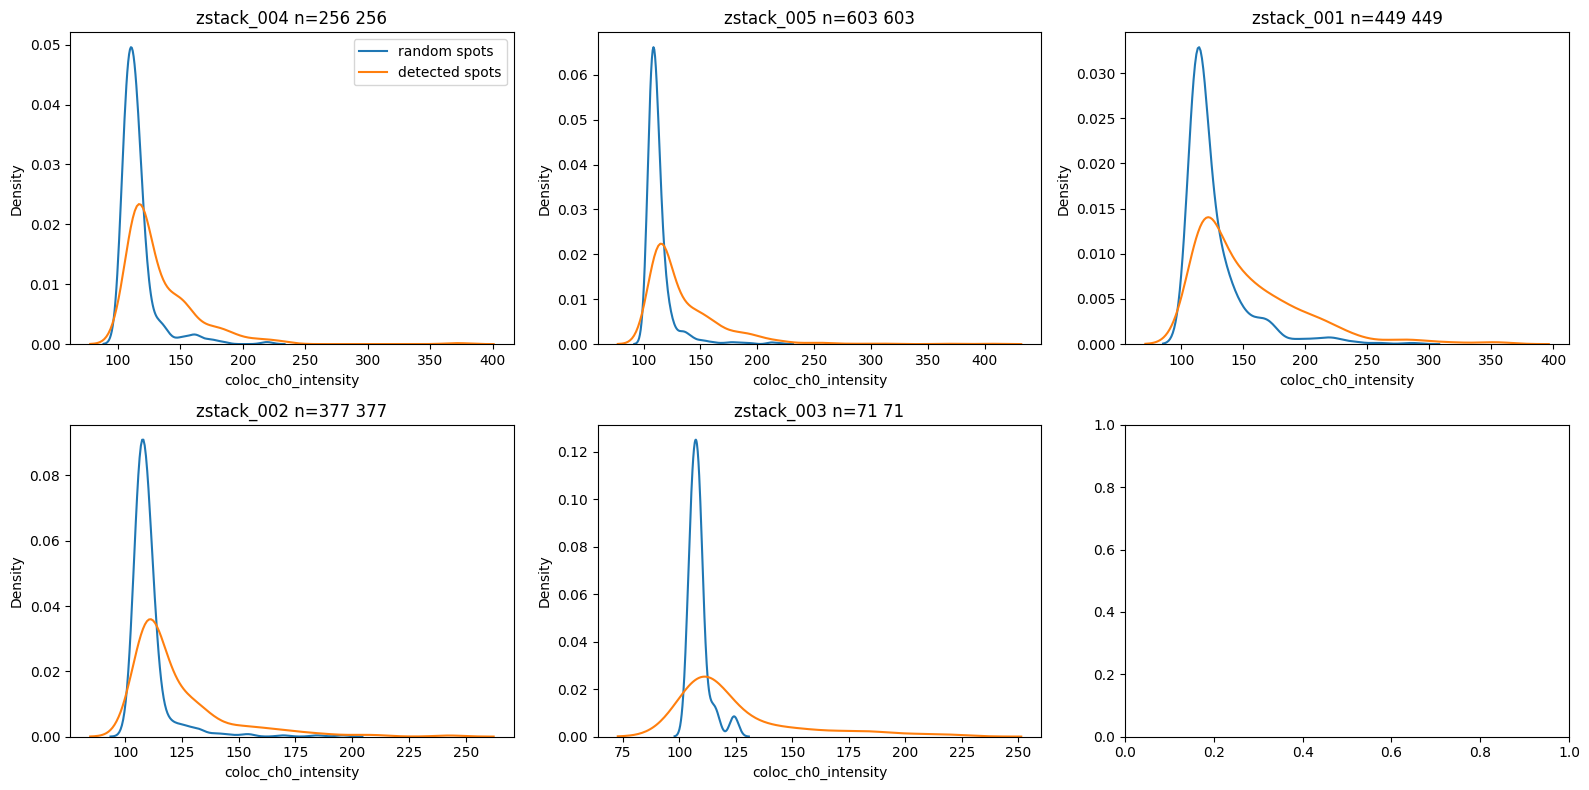

In [73]:
fig,axs=plt.subplots(2, 3, figsize=(16,8)) #, sharex=True, sharey=True)
ncols=3
i=0; j=0
loc="cytoplasmic"
for file_name in df_dox.file_name.unique():
    cur_df = df_dox[(df_dox.file_name==file_name) & (df_dox.location==loc)]
    cur_random_df = df_dox_random[(df_dox_random.file_name==file_name) & (df_dox_random.location==loc)]

    data = cur_df[coloc_ch_col]
    data_random = cur_random_df[coloc_ch_col]

    sns.kdeplot(x=data_random, ax=axs[i][j], label='random spots')
    sns.kdeplot(x=data, ax=axs[i][j], label='detected spots')
    
    #sns.histplot(x=data_random, ax=axs[i][j], label='random spots', element="step", 
    #             fill=False, stat="percent", bins=np.arange(70,300,10))
    #sns.histplot(x=data, ax=axs[i][j], label='detected spots', element="step", 
    #             fill=False, stat="percent", bins=np.arange(70,300,10))

    axs[i][j].set_title(f"{file_name} n={len(data)} {len(data_random)}")
    if(i==0 and j==0):
        axs[i][j].legend()
    
    if(j == (ncols-1)):
        i+=1; j=0
    else:
        j+=1

plt.tight_layout()
plt.savefig(f"{home_dir}/{img_dir}/dox/results/results-kde.pdf")
plt.show()

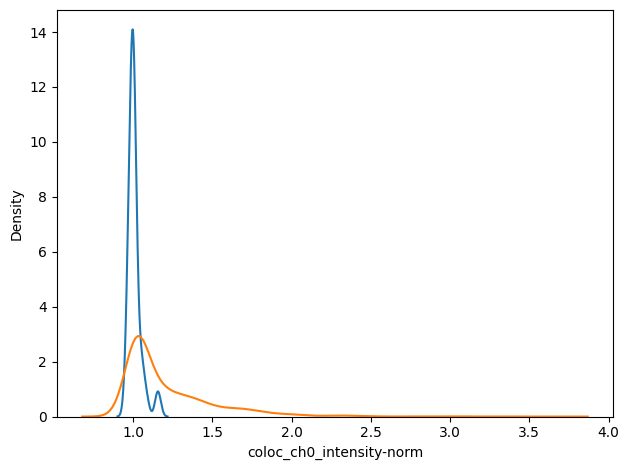

In [74]:
loc='cytoplasmic'
cur_df = df_dox[df_dox.location==loc]
cur_df_random = df_dox_random[df_dox_random.location==loc]

data = cur_df[f"{coloc_ch_col}-norm"]
data_random = cur_random_df[f"{coloc_ch_col}-norm"]

sns.kdeplot(x=data_random, label='random spots')
sns.kdeplot(x=data, label='detected spots')


plt.tight_layout()
plt.savefig(f"{home_dir}/{img_dir}/dox/results/results-kde-all-norm.pdf")
plt.show()

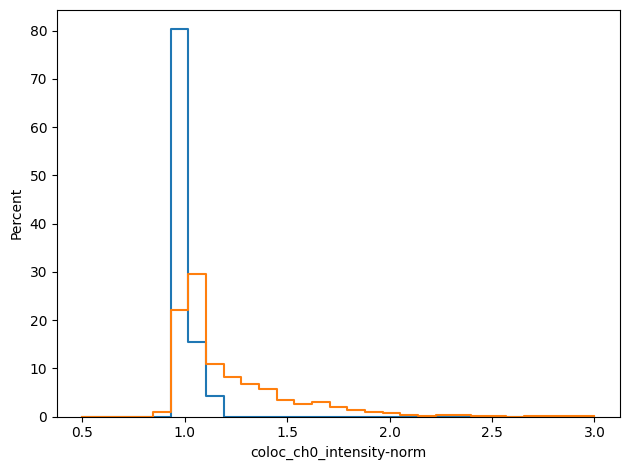

In [75]:
loc='cytoplasmic'
cur_df = df_dox[df_dox.location==loc]
cur_df_random = df_dox_random[df_dox_random.location==loc]

data = cur_df[f"{coloc_ch_col}-norm"]
data_random = cur_random_df[f"{coloc_ch_col}-norm"]

#sns.kdeplot(x=data_random, label='random spots')
#sns.kdeplot(x=data, label='detected spots')
    
sns.histplot(x=data_random, label='random spots', element="step", 
             fill=False, stat="percent", bins=np.linspace(0.5,3,30))
sns.histplot(x=data, label='detected spots', element="step", 
             fill=False, stat="percent", bins=np.linspace(0.5,3,30))

plt.tight_layout()
plt.savefig(f"{home_dir}/{img_dir}/dox/results/results-hist-all-norm.pdf")
plt.show()

In [76]:
for file_name in df_dox.file_name.unique():
    print(file_name)
    print(len(df_dox[df_dox.file_name==file_name]['roi'].unique()))

zstack_004
4
zstack_005
9
zstack_001
5
zstack_002
4
zstack_003
4


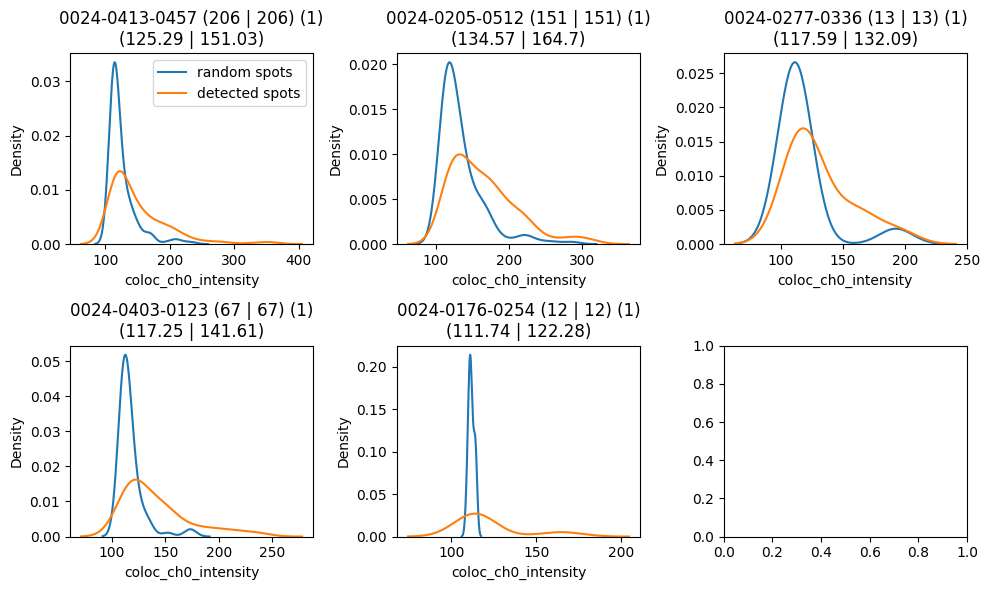

In [77]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_001', 'cytoplasmic', False, 2, 3, (10,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_001', 'nuclear', False, 2, 3, (10,6))

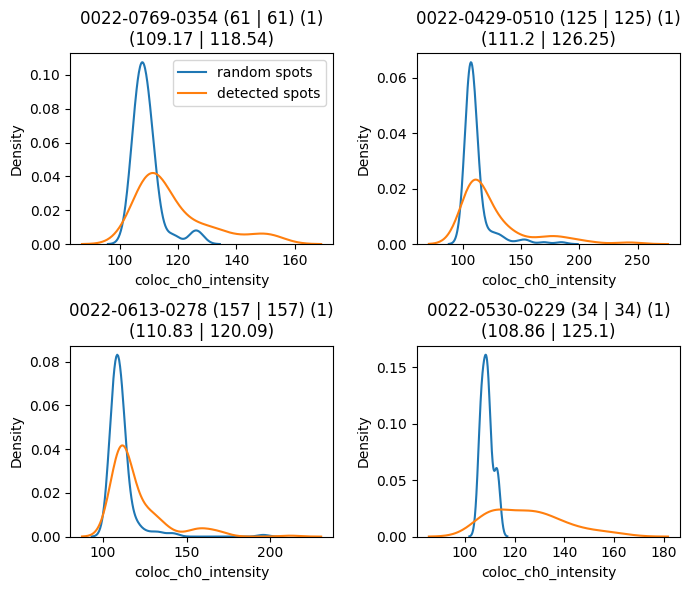

In [60]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_002', 'cytoplasmic', False, 2, 2, (7,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_002', 'nuclear', False, 2, 2, (7,6))

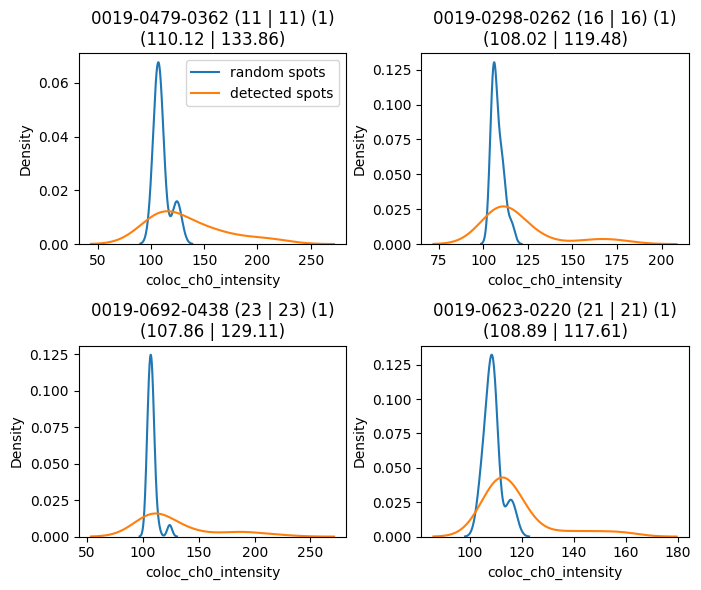

In [61]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_003', 'cytoplasmic', False, 2, 2, (7,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_003', 'nuclear', False, 2, 2, (7,6))

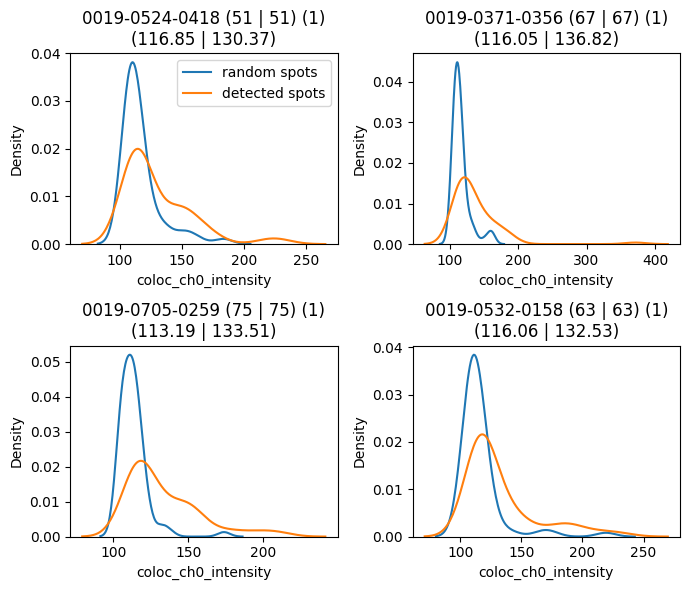

In [62]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_004', 'cytoplasmic', False, 2, 2, (7,6))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_004', 'nuclear', False, 2, 2, (7,6))

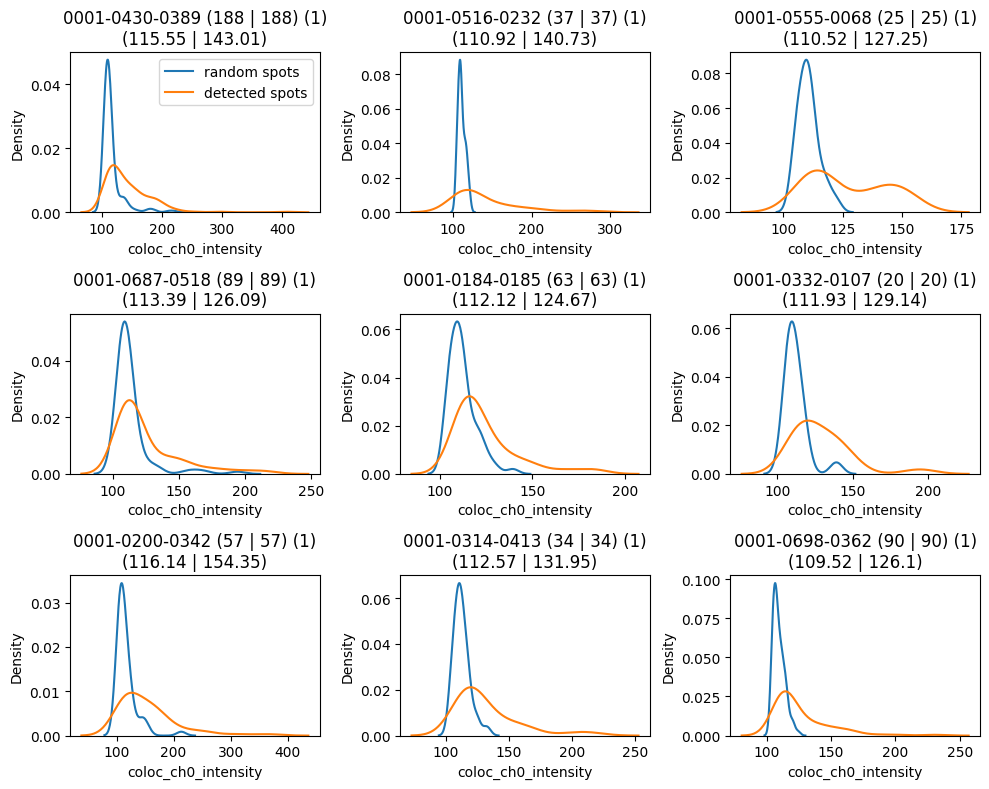

In [63]:
plot_intensity_kde(df_dox, df_dox_random, 'zstack_005', 'cytoplasmic', False, 3, 3, (10,8))
#plot_intensity_kde(df_dox, df_dox_random, 'zstack_005', 'nuclear', False, 3, 3, (10,8))

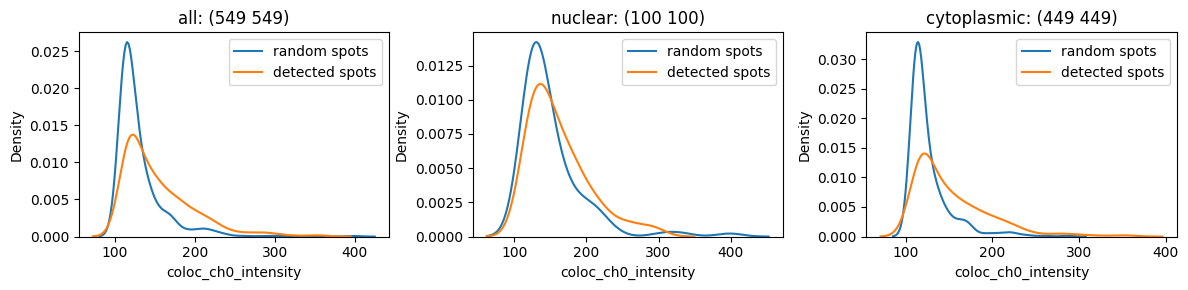

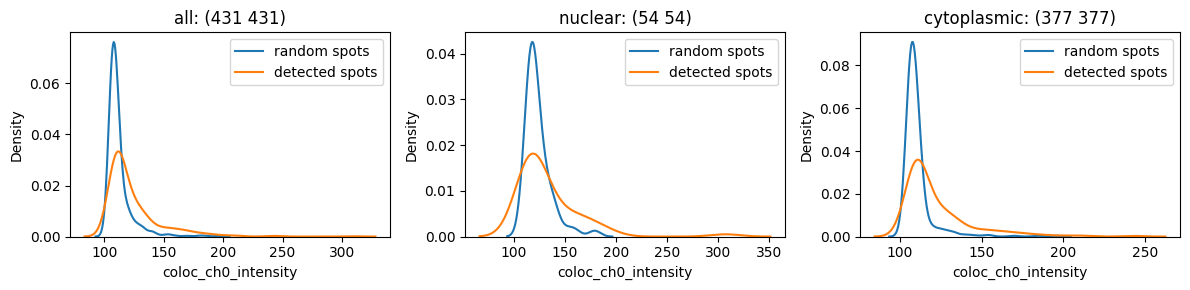

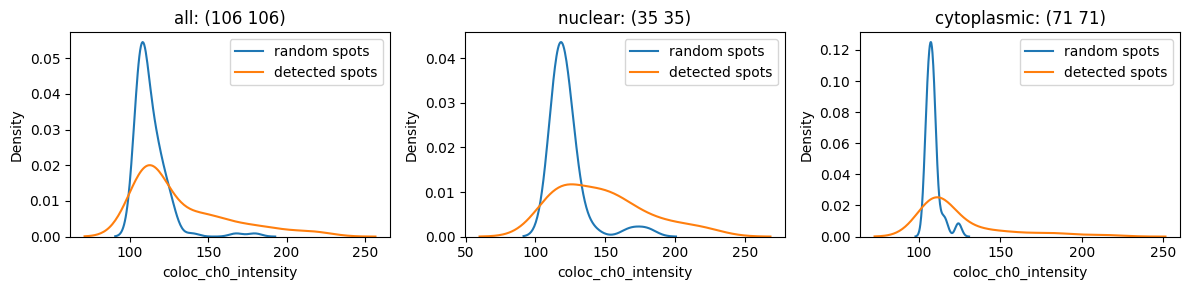

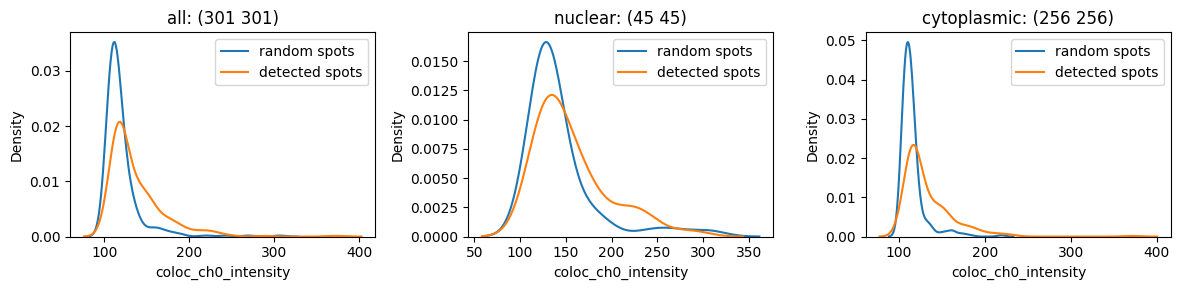

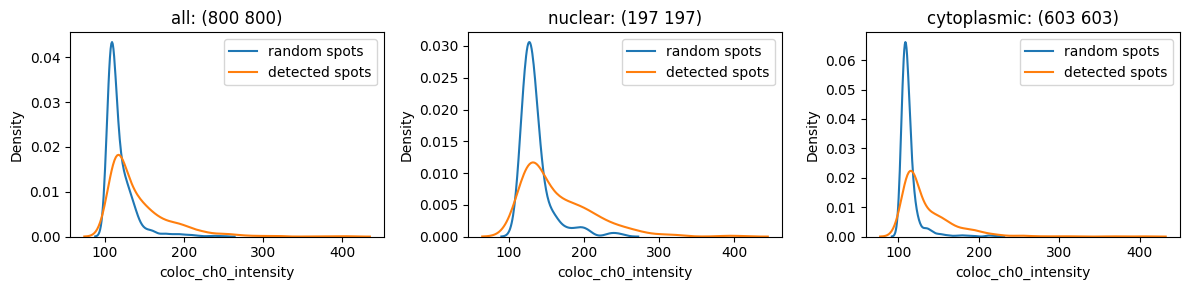

In [64]:
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_001')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_002')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_003')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_004')
plot_intensity_kde2(df_dox, df_dox_random, 'zstack_005')